## Part 0: Load Data, packages

In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import clip
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import cv2
import copy
from tqdm import tqdm
import time
from sklearn.model_selection import GridSearchCV

In [352]:
data = pd.read_csv('../Data/instagram_data.csv')

## Part 1: Data Exploration

### 1.1 Overview

In [353]:
data.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg


In [354]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   likes                3785 non-null   int64 
 1   no_of_comments       3785 non-null   int64 
 2   t                    3785 non-null   int64 
 3   follower_count_at_t  3785 non-null   int64 
 4   image_path           3785 non-null   object
dtypes: int64(4), object(1)
memory usage: 148.0+ KB


### 1.2 Exclude erroneous data

In [355]:
if data['image_path'].duplicated().sum()==0:
  print('No duplicated post')

No duplicated post


### 1.3 Check missing data

In [356]:
data.isnull().sum()

likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64

### 1.4 Explore numerical features distribution

#### 1.4.1 response 

In [357]:
data.describe()

,likes,no_of_comments,t,follower_count_at_t
count,3.785000e+03,3785.000000,3.785000e+03,3.785000e+03
mean,1.832536e+05,2531.382827,1.585137e+09,1.409485e+07
std,1.936969e+05,21064.081137,1.322603e+07,9.402605e+06
min,1.431000e+03,0.000000,1.489547e+09,1.870000e+02
25%,5.208700e+04,194.000000,1.582540e+09,7.296298e+06
50%,1.236640e+05,484.000000,1.588855e+09,1.104970e+07
75%,2.431440e+05,1337.000000,1.592738e+09,1.836292e+07
max,2.161369e+06,733973.000000,1.594541e+09,4.093447e+07


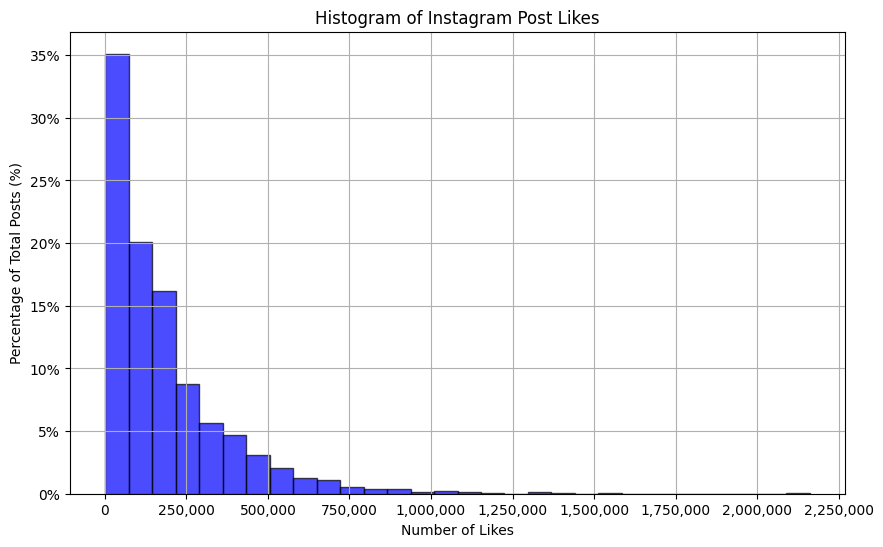

In [358]:
weights = (np.ones_like(data['likes']) / len(data['likes'])) * 100
plt.figure(figsize=(10, 6))
plt.hist(data['likes'], bins=30, weights=weights, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Instagram Post Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Percentage of Total Posts (%)')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.grid(True)
plt.show()

As can be seen from the above figure, the distribution of the number of Instagram post likes is skewed, more than 50% of posts gets like count below than the average. This distribution can be consider as long tail distribution, which indicates that the majority of the posts have a relatively low like count. 

Also, it can be categorically segmented into 'low', 'medium', and 'high' categories based on the number of likes.

In [359]:
data['class'] = pd.qcut(data['likes'], 3, labels=["low", "medium", "high"])

In [360]:
quantile_1 = data['likes'].quantile(1/3)
quantile_2 = data['likes'].quantile(2/3)

print(f"First tertile cutoff: {quantile_1}")
print(f"Second tertile cutoff: {quantile_2}")

First tertile cutoff: 68969.99999999999
Second tertile cutoff: 192844.33333333328


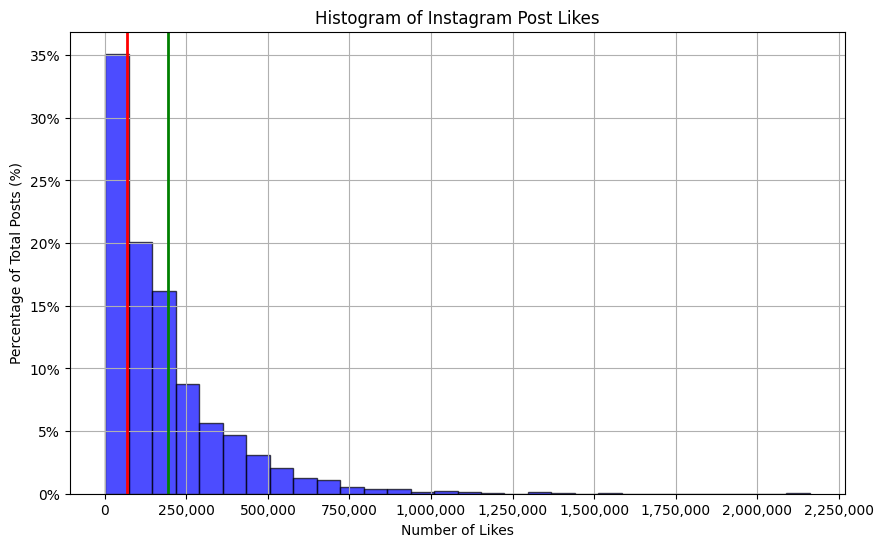

In [361]:
weights = (np.ones_like(data['likes']) / len(data['likes'])) * 100
plt.figure(figsize=(10, 6))
plt.hist(data['likes'], bins=30, weights=weights, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(quantile_1, color='red', linewidth=2)
plt.axvline(quantile_2, color='green', linewidth=2)
plt.title('Histogram of Instagram Post Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Percentage of Total Posts (%)')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.grid(True)
plt.show()

The histogram now displays the quantile thresholds as solid lines. The red line shows the first tertile cutoff and the green line the second tertile cutoff. These solid lines indicate where the data is split into 'low', 'medium', and 'high' categories based on the number of likes.

#### 1.4.2 `no_of_comments` feature

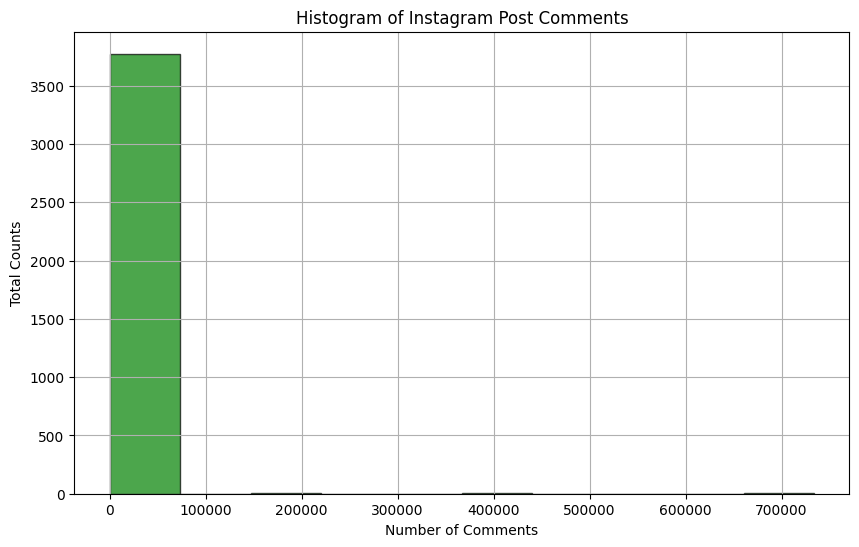

In [362]:
plt.figure(figsize=(10, 6))
plt.hist(data['no_of_comments'], color='green', edgecolor='black', alpha=0.7)
plt.title('Histogram of Instagram Post Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Total Counts')
plt.grid(True)
plt.show()

As can be seen from the above histogram, the distribution of `no_of_comments` is highly skewed. Compute the distribution statistics for further analysis.

In [363]:
data['no_of_comments'].describe(percentiles=[0,0.25,0.5,0.75,0.9,0.95])

count      3785.000000
mean       2531.382827
std       21064.081137
min           0.000000
0%            0.000000
25%         194.000000
50%         484.000000
75%        1337.000000
90%        3458.600000
95%        6067.200000
max      733973.000000
Name: no_of_comments, dtype: float64

As can be seen from the above table, the `no_of_comments` feature is heavily right-skewed, indicated by a mean (2,531.38) that is much higher than the median (484). A sharp increase in values at the higher percentiles (3,458.6 at 90% and 6,067.2 at 95%) indicates that the top 5-10% of observations are substantially higher than the rest. The maximum value (733,973) is an extreme outlier, much higher than even the 95th percentile. This suggests that such high values are rare but have a substantial impact on the overall distribution. Since the number of comments can be seen as the social media engagement, the data suggests that while most posts/activities have modest engagement, a few have exceptionally high engagement.

#### 1.4.3 `follower_count_at_t` feature

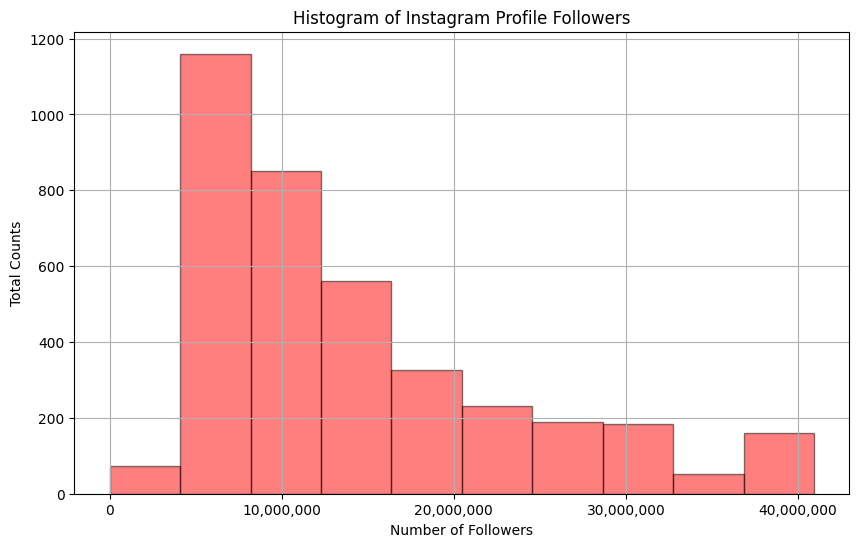

In [364]:
plt.figure(figsize=(10, 6))
plt.hist(data['follower_count_at_t'], color='red', edgecolor='black', alpha=0.5)
plt.title('Histogram of Instagram Profile Followers')
plt.xlabel('Number of Followers')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Total Counts')
plt.grid(True)
plt.show()

Compared to the above two features, the `follower_count_at_t` feature distributed more uniformly.

### 1.5 Check outliers

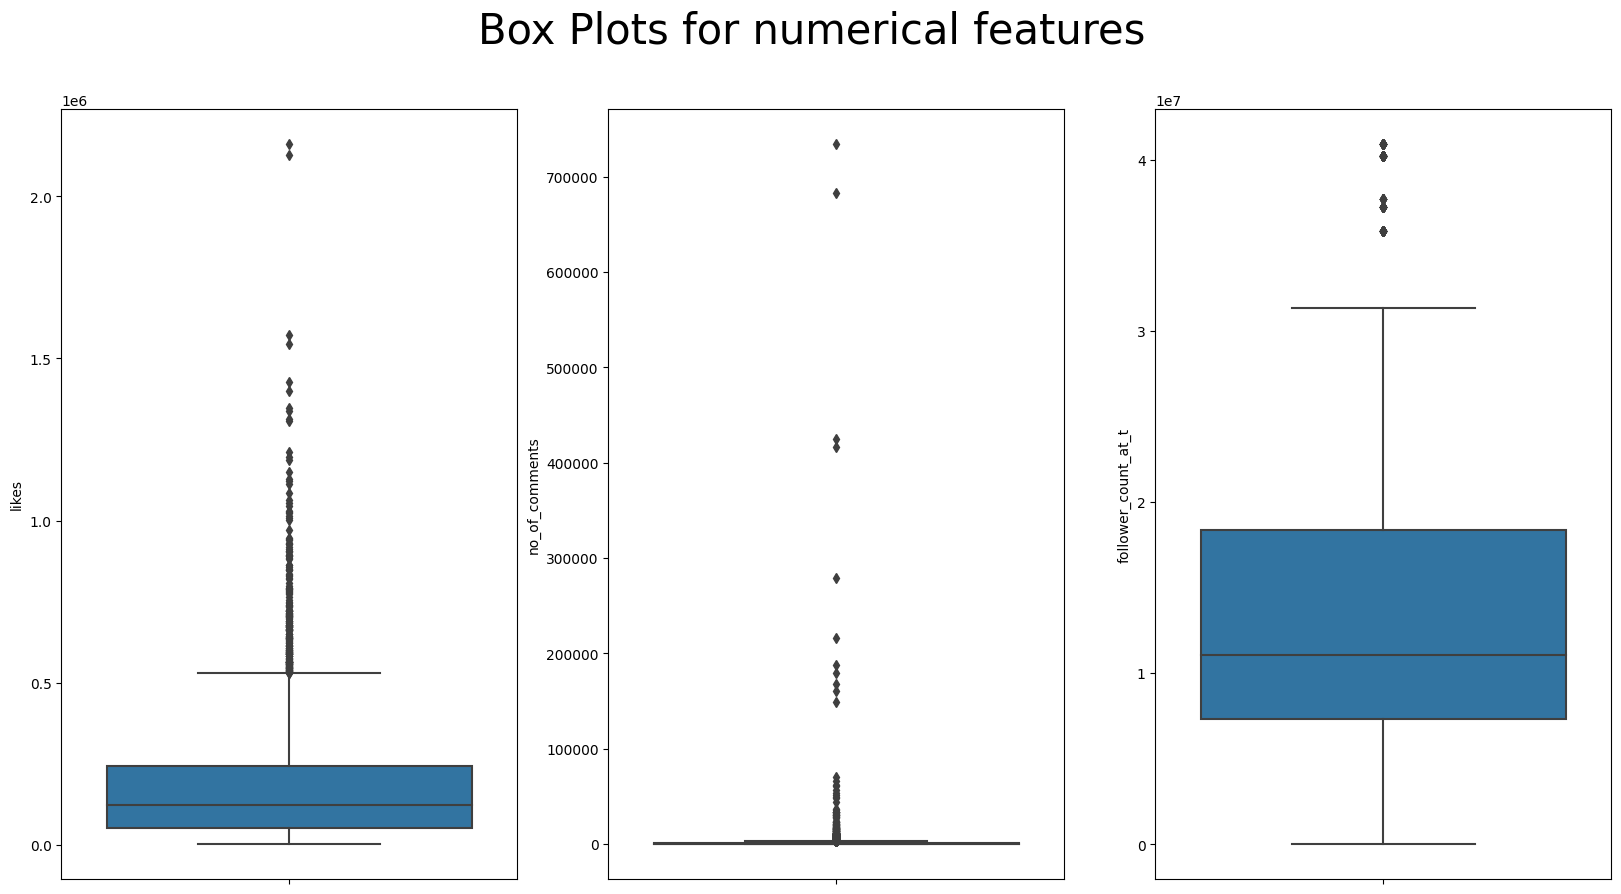

In [365]:
_, axes = plt.subplots(1,3, figsize=[20,10])  
sns.boxplot(y ='likes', data=data, ax=axes[0])
sns.boxplot(y ='no_of_comments', data=data, ax=axes[1])
sns.boxplot(y ='follower_count_at_t', data=data, ax=axes[2])
plt.suptitle('Box Plots for numerical features', fontsize=30)
plt.show()

Allign with the analysis presented in the section 1.4, the feature `no_of_comments` exhibits outliers, which may need further process.

## Part 2: Data Preprocessing

### 2.1 Convert time type

In [366]:
data['t'] = pd.to_datetime(data['t'], unit='s')

In [367]:
data.head()

,likes,no_of_comments,t,follower_count_at_t,image_path,class
0,154552,0,2020-07-08 02:06:49,40934474,../Data/insta_data/0.jpg,medium
1,97386,0,2020-07-01 02:47:46,40934474,../Data/insta_data/2.jpg,medium
2,145632,0,2020-06-26 01:52:21,40934474,../Data/insta_data/4.jpg,medium
3,76461,0,2020-06-24 06:44:07,40934474,../Data/insta_data/6.jpg,medium
4,174620,0,2020-06-21 01:37:41,40934474,../Data/insta_data/8.jpg,medium


### 2.2 Remove outliers

In [368]:
data[(data['likes']) > 2e6]

,likes,no_of_comments,t,follower_count_at_t,image_path,class
591,2161369,37106,2020-05-28 08:11:25,21737604,../Data/insta_data/1471.jpg,high
593,2127367,17250,2020-05-24 04:15:59,21737604,../Data/insta_data/1474.jpg,high


In [369]:
data['no_of_comments'].describe(percentiles=np.linspace(0.9,1.0,11))

count      3785.000000
mean       2531.382827
std       21064.081137
min           0.000000
50%         484.000000
90%        3458.600000
91%        3785.440000
92%        4117.280000
93%        4705.360000
94%        5300.040000
95%        6067.200000
96%        7424.240000
97%        9450.800000
98%       13088.040000
99%       23331.520000
100%     733973.000000
max      733973.000000
Name: no_of_comments, dtype: float64

In [370]:
data[(data['no_of_comments']) > 100000]

,likes,no_of_comments,t,follower_count_at_t,image_path,class
49,44899,148536,2020-07-08 11:35:52,37229501,../Data/insta_data/194.jpg,low
70,64193,179496,2020-06-13 11:30:22,37229501,../Data/insta_data/254.jpg,low
71,81200,187754,2020-06-07 02:05:45,37229501,../Data/insta_data/260.jpg,medium
72,61245,167991,2020-06-06 08:17:44,37229501,../Data/insta_data/263.jpg,low
81,158977,733973,2020-05-22 11:01:59,37229501,../Data/insta_data/297.jpg,medium
471,358794,279364,2020-06-20 04:30:13,25510324,../Data/insta_data/1163.jpg,high
884,662093,160827,2020-05-13 08:08:13,24744858,../Data/insta_data/2043.jpg,high
932,86207,415940,2020-06-20 12:26:25,21735444,../Data/insta_data/2134.jpg,medium
3143,574494,682323,2020-05-24 11:42:53,5978085,../Data/insta_data/7483.jpg,high
3144,320695,425096,2020-05-23 09:39:10,5978085,../Data/insta_data/7484.jpg,high


In [371]:
data[(data['follower_count_at_t'] > 4e7)]['follower_count_at_t'].unique()

array([40934474, 40220549])

There are basically 2 bloggers who get followers greater than 40 millions.

In [372]:
data_cleaned = data[(data['likes'] < 2e6)]
data_cleaned = data_cleaned[(data_cleaned['no_of_comments']) < 100000]
data_cleaned = data_cleaned[(data_cleaned['follower_count_at_t'] < 4e7)]

In [373]:
data_cleaned.shape

(3656, 6)

### 2.3 Feature Engineering

In [374]:
data_new = data_cleaned.copy()
data_new['comments_to_followers_ratio'] = data_cleaned['no_of_comments'] / data_cleaned['follower_count_at_t']

In [375]:
# Extracting numerical features from datetime
data_new['year'] = data_new['t'].dt.year
data_new['month'] = data_new['t'].dt.month
data_new['day'] = data_new['t'].dt.day
data_new['weekday'] = data_new['t'].dt.weekday
data_new['hour'] = data_new['t'].dt.hour

In [376]:
data_new = data_new.drop(['likes', 't'], axis=1)
data_new.head()

,no_of_comments,follower_count_at_t,image_path,class,comments_to_followers_ratio,year,month,day,weekday,hour
38,584,37729625,../Data/insta_data/93.jpg,medium,0.000015,2020,6,23,1,4
39,1581,37729625,../Data/insta_data/96.jpg,high,0.000042,2020,6,22,0,2
40,510,37729625,../Data/insta_data/97.jpg,medium,0.000014,2020,6,22,0,1
41,364,37729625,../Data/insta_data/102.jpg,medium,0.000010,2020,6,6,5,12
42,975,37729625,../Data/insta_data/116.jpg,high,0.000026,2020,4,23,3,12


### 2.4 Correlation among numerical features

In [377]:
data_new.columns

Index(['no_of_comments', 'follower_count_at_t', 'image_path', 'class',
       'comments_to_followers_ratio', 'year', 'month', 'day', 'weekday',
       'hour'],
      dtype='object')

<Axes: >

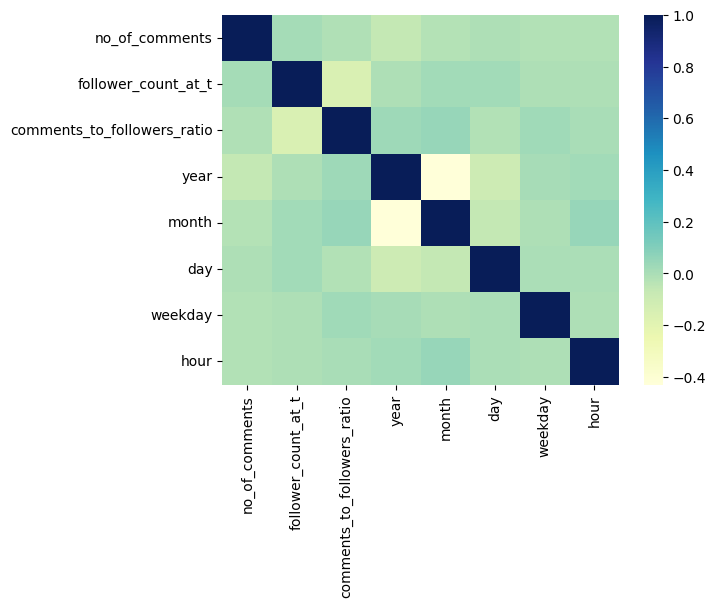

In [378]:
corr = data_new[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day', 'weekday','hour']].corr()
sns.heatmap(corr, cmap="YlGnBu")

## Part 3: Simple Models Training without Pictures

### 3.1 Datasets splitting

In [379]:
X = data_new[['no_of_comments', 'follower_count_at_t', 'image_path', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']]
y = data_new['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [380]:
print('Training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('Test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

Training data has 2924 observation with 9 features
Test data has 732 observation with 9 features


In [381]:
X_train.head()

,no_of_comments,follower_count_at_t,image_path,comments_to_followers_ratio,year,month,day,weekday,hour
1734,132,11920047,../Data/insta_data/3876.jpg,0.000011,2020,7,2,3,15
1463,125,14818369,../Data/insta_data/3265.jpg,0.000008,2019,12,30,0,9
990,39,17607651,../Data/insta_data/2322.jpg,0.000002,2019,9,3,1,9
118,1407,35860886,../Data/insta_data/377.jpg,0.000039,2020,4,21,1,10
3244,116,5822618,../Data/insta_data/7754.jpg,0.000020,2020,4,5,6,4


### 3.2 Feature scaling

In [382]:
scaler = MinMaxScaler()
scaler.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])
X_train_scaled = scaler.transform(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])
X_test_scaled = scaler.transform(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])

In [383]:
X_train_scaled 

array([[1.86741363e-03, 3.15929964e-01, 8.58539471e-07, ...,
        3.33333333e-02, 5.00000000e-01, 6.52173913e-01],
       [1.76838412e-03, 3.92748548e-01, 6.53994221e-07, ...,
        9.66666667e-01, 0.00000000e+00, 3.91304348e-01],
       [5.51735846e-04, 4.66677081e-01, 1.71722613e-07, ...,
        6.66666667e-02, 1.66666667e-01, 3.91304348e-01],
       ...,
       [7.96480208e-03, 5.76082183e-01, 2.00818714e-06, ...,
        4.66666667e-01, 0.00000000e+00, 5.65217391e-01],
       [1.25908949e-03, 2.19986871e-01, 8.31318465e-07, ...,
        8.33333333e-01, 1.00000000e+00, 5.21739130e-01],
       [4.48603684e-02, 1.32337116e-01, 4.92359451e-05, ...,
        4.00000000e-01, 8.33333333e-01, 5.21739130e-01]])

### 3.3 Models training 

In [384]:
model_rf = RandomForestClassifier(random_state=22)
model_rf.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']], y_train)
y_pred_rf = model_rf.predict(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])
# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy for random forest: {accuracy_rf}")

Accuracy for random forest: 0.7759562841530054


In [385]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']], y_train)
y_pred_knn = model_knn.predict(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy for knn: {accuracy_knn}")

Accuracy for knn: 0.8032786885245902


In [386]:
# using scaled data for training knn
model_knn_2 = KNeighborsClassifier(n_neighbors=5)
model_knn_2.fit(X_train_scaled, y_train)
y_pred_knn_2 = model_knn_2.predict(X_test_scaled)
accuracy_knn_2 = accuracy_score(y_test, y_pred_knn_2)
print(f"Accuracy for knn using scaled data: {accuracy_knn_2}")

Accuracy for knn using scaled data: 0.4344262295081967


In [387]:
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=22)
gbm_classifier.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']], y_train)
y_pred_gbm = gbm_classifier.predict(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour']])
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f"Accuracy for gradient boosting: {accuracy_gbm}")

Accuracy for gradient boosting: 0.7663934426229508


As can be seen from the above result, training simple models using just metadata without pitures can get pretty good accuracy score, and using scaled data actually worsens the accuracy score. 

In the next section check the features importance of random forest.

### 3.4 Check features importance

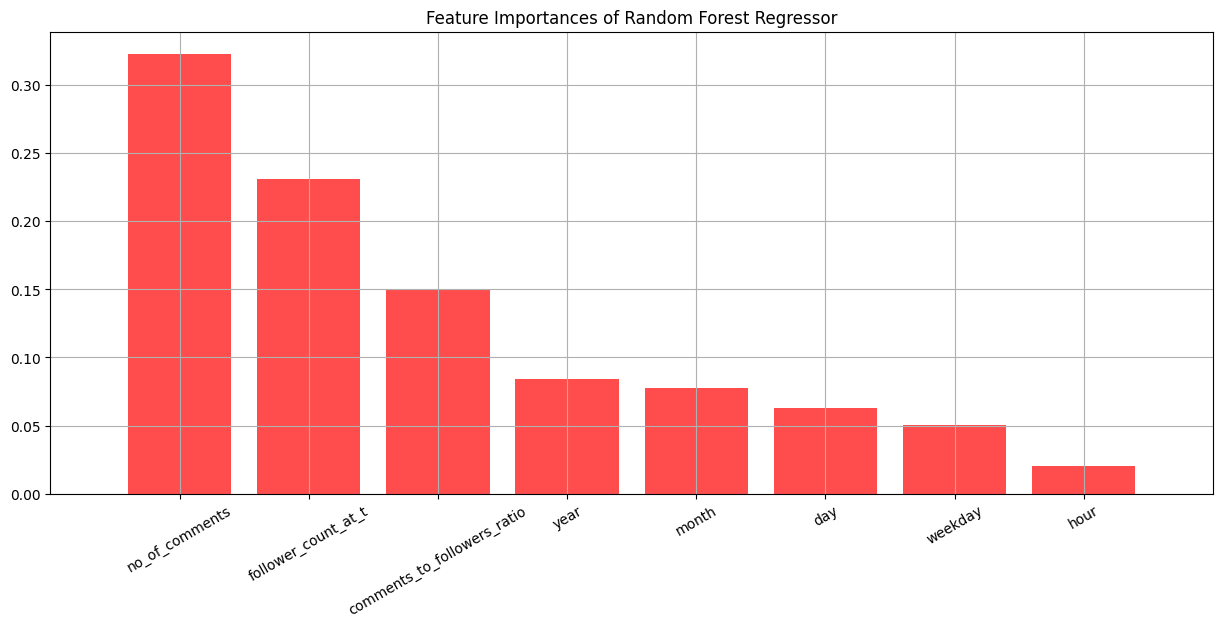

In [388]:
importances = model_rf.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 6))
plt.title("Feature Importances of Random Forest Regressor")
plt.bar(range(X_train.shape[1] - 1), importances[indices], color="r", alpha=0.7, align='center')
plt.xticks(range(X_train.shape[1] - 1), ['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio', 'year', 'month', 'day','weekday', 'hour'], rotation=30)
plt.xlim([-1, X_train.shape[1] - 1])
plt.grid(True)
plt.show()

Judging from the feature importances computed by the random forest model, the release time of the posts does not provide much useful information in predicting the response. The most important features are `no_of_comments` and `follower_count_at_t`. 

### 3.5 Retrain simple model using just a fraction of features

In [389]:
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [390]:
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier() , parameters, cv=5)
Grid_KNN.fit(X_train[['no_of_comments', 'follower_count_at_t']], y_train)
print_grid_search_metrics(Grid_KNN)

Best score: 0.7910484720758694
Best parameters set:
n_neighbors:5


In [391]:
model_rf_21 = RandomForestClassifier(random_state=22)
model_rf_21.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio']], y_train)
y_pred_rf_21 = model_rf_21.predict(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio']])
# Evaluate accuracy
accuracy_rf_21 = accuracy_score(y_test, y_pred_rf_21)
print(f"Accuracy for random forest using just a fraction of features: {accuracy_rf_21}")

Accuracy for random forest using just a fraction of features: 0.744535519125683


In [392]:
model_rf_22 = RandomForestClassifier(random_state=22)
model_rf_22.fit(X_train[['no_of_comments', 'follower_count_at_t']], y_train)
y_pred_rf_22 = model_rf_22.predict(X_test[['no_of_comments', 'follower_count_at_t']])
# Evaluate accuracy
accuracy_rf_22 = accuracy_score(y_test, y_pred_rf_22)
print(f"Accuracy for random forest using just 2 features: {accuracy_rf_22}")

Accuracy for random forest using just 2 features: 0.7663934426229508


In [393]:
model_knn_21 = KNeighborsClassifier(n_neighbors=5)
model_knn_21.fit(X_train[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio']], y_train)
y_pred_knn_21 = model_knn_21.predict(X_test[['no_of_comments', 'follower_count_at_t', 'comments_to_followers_ratio']])
accuracy_knn_21 = accuracy_score(y_test, y_pred_knn_21)
print(f"Accuracy for knn using just a fraction of features: {accuracy_knn_21}")

Accuracy for knn using just a fraction of features: 0.8019125683060109


In [291]:
model_knn_22 = KNeighborsClassifier(n_neighbors=5)
model_knn_22.fit(X_train[['no_of_comments', 'follower_count_at_t']], y_train)
y_pred_knn_22 = model_knn_22.predict(X_test[['no_of_comments', 'follower_count_at_t']])
accuracy_knn_22 = accuracy_score(y_test, y_pred_knn_22)
print(f"Accuracy for knn using just 2 features: {accuracy_knn_22}")

Accuracy for knn using just 2 features: 0.8019125683060109


Whether using the engineered feature `comments_to_followers_ratio` does not make much of a difference in terms of predicting accuracy. The overall accuracy score using just metadata without pictures can achieve 80% on test set. 

## Part 4: Model Training using Transfer Learning method

### 4.1 Training only pictures 

#### 4.1.1 Data ETL Pipeline building

In [292]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

In [293]:
train_image_paths = X_train['image_path'].tolist()
test_image_paths = X_test['image_path'].tolist()

In [294]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_labels_train = label_encoder.transform(y_train)
encoded_labels_test = label_encoder.transform(y_test)
idx_to_class_train = {i:j for i, j in enumerate(encoded_labels_train)}
idx_to_class_test = {i:j for i, j in enumerate(encoded_labels_test)}

In [295]:
original_labels = label_encoder.classes_
label_to_encoded = {label: index for index, label in enumerate(original_labels)}
print("Label to Encoded:", label_to_encoded)

Label to Encoded: {'high': 0, 'low': 1, 'medium': 2}


In [296]:
# Define dataset class
class Insta_Dataset(Dataset):
    def __init__(self, image_paths, idx_to_class, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.idx_to_class = idx_to_class
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        label = self.idx_to_class[idx]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    

In [297]:
train_dataset = Insta_Dataset(train_image_paths, idx_to_class_train, transform)
test_dataset = Insta_Dataset(test_image_paths, idx_to_class_test, transform) 

In [298]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

#### 4.1.2 Model Traininig

In [299]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
device = torch.device("mps")

True
True


In [300]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=10):

    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 8 * running_correct / len(trainloader) #(100 * correct) / (8 * len(trainloader))
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [301]:
# This function is called out after each epoch of training on the training data to measure the accuracy of the model
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

In [302]:
NUM_CLASSES = 3
model_ft = models.resnet34(pretrained=True)  
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/Users/wangyufei/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wangyufei/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [303]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 89 s, loss: 1.5337, acc: 36.1680


 10%|█         | 1/10 [01:45<15:49, 105.55s/it]

Accuracy of the network on the test images: 39 %
Epoch 2, duration: 87 s, loss: 1.1925, acc: 34.5287


 20%|██        | 2/10 [03:28<13:53, 104.18s/it]

Accuracy of the network on the test images: 34 %
Epoch 3, duration: 87 s, loss: 1.1040, acc: 37.7049


 30%|███       | 3/10 [05:12<12:06, 103.78s/it]

Accuracy of the network on the test images: 40 %
Epoch 4, duration: 87 s, loss: 1.0968, acc: 37.3634


 40%|████      | 4/10 [06:55<10:21, 103.58s/it]

Accuracy of the network on the test images: 37 %
Epoch 5, duration: 86 s, loss: 1.0951, acc: 39.1735


 50%|█████     | 5/10 [08:38<08:37, 103.43s/it]

Accuracy of the network on the test images: 36 %
Epoch 6, duration: 87 s, loss: 1.0766, acc: 38.3538


 60%|██████    | 6/10 [10:21<06:53, 103.37s/it]

Accuracy of the network on the test images: 39 %
Epoch 7, duration: 87 s, loss: 1.0726, acc: 39.9590


 70%|███████   | 7/10 [12:05<05:10, 103.37s/it]

Accuracy of the network on the test images: 39 %
Epoch 8, duration: 87 s, loss: 1.0700, acc: 39.7541


 80%|████████  | 8/10 [13:48<03:27, 103.50s/it]

Accuracy of the network on the test images: 36 %
Epoch 9, duration: 87 s, loss: 1.0749, acc: 40.3005


 90%|█████████ | 9/10 [15:32<01:43, 103.53s/it]

Accuracy of the network on the test images: 38 %
Epoch 10, duration: 86 s, loss: 1.0693, acc: 41.0178


100%|██████████| 10/10 [17:15<00:00, 103.55s/it]

Accuracy of the network on the test images: 38 %
Finished Training


### 4.2 Training with all data

#### 4.2.1 Data ETL Pipeline building

In [306]:
class Overall_Dataset(Dataset):
    def __init__(self, data, image_paths, idx_to_class, transform=False):
        self.data = torch.tensor(data.values.astype(np.float32))
        self.image_paths = image_paths
        self.transform = transform
        self.idx_to_class = idx_to_class
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        num = self.data[idx]
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        label = self.idx_to_class[idx]
        if self.transform is not None:
            image = self.transform(image)
        
        return num, image, label
    

In [307]:
train_dataset = Overall_Dataset(X_train[['no_of_comments', 'follower_count_at_t']], train_image_paths, idx_to_class_train, transform)
test_dataset = Overall_Dataset(X_test[['no_of_comments', 'follower_count_at_t']], test_image_paths, idx_to_class_test, transform) 

In [308]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

#### 4.2.2 Model building

In [309]:
class Dnn(nn.Module):
    
    def __init__(self, hidden_units, dropout_rate=0., use_bn = False):

        super(Dnn, self).__init__()
        self.model_ft = models.resnet34(pretrained=True) 
        self.model_ft.fc = nn.Linear(model_ft.fc.in_features, 3)
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout_rate)
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])
        self.fc = nn.Linear(hidden_units[-1] + 3, 3)
    
    def forward(self, x, img):
        for i, linear in enumerate(self.dnn_network):
            x = linear(x)
            if self.use_bn:
                x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        xx = self.model_ft(img)
        fc_input = torch.cat([x, xx], dim=-1) 
        output = self.fc(fc_input)

        return output

In [310]:
def train_model_2(model, criterion, optimizer, n_epochs=10):

    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            num, img, labels = data
            num = num.to(device)
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(num, img)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 8 * running_correct / len(trainloader) #(100 * correct) / (8 * len(trainloader))
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model_2(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [311]:
# This function is called out after each epoch of training on the training data to measure the accuracy of the model
def eval_model_2(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            num, img, labels = data
            num = num.to(device)
            img = img.to(device)
            labels = labels.to(device)
            outputs = model(num, img)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

In [312]:
hidden_units = [2, 16, 32]
dnn_dropout = 0.65
model_2 = Dnn(hidden_units, dnn_dropout, use_bn=True)
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
model_2.to(device)

/Users/wangyufei/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wangyufei/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dnn(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [313]:
model, training_losses, training_accs, test_accs = train_model_2(model_2, criterion, optimizer, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 91 s, loss: 1.1761, acc: 34.7336


 10%|█         | 1/10 [01:47<16:10, 107.84s/it]

Accuracy of the network on the test images: 35 %
Epoch 2, duration: 90 s, loss: 1.1097, acc: 36.9536


 20%|██        | 2/10 [03:33<14:14, 106.80s/it]

Accuracy of the network on the test images: 37 %
Epoch 3, duration: 90 s, loss: 1.0968, acc: 37.5000


 30%|███       | 3/10 [05:20<12:27, 106.84s/it]

Accuracy of the network on the test images: 37 %
Epoch 4, duration: 91 s, loss: 1.0832, acc: 38.5587


 40%|████      | 4/10 [07:07<10:41, 106.96s/it]

Accuracy of the network on the test images: 39 %
Epoch 5, duration: 90 s, loss: 1.0817, acc: 38.7295


 50%|█████     | 5/10 [08:54<08:54, 106.98s/it]

Accuracy of the network on the test images: 40 %
Epoch 6, duration: 91 s, loss: 1.0789, acc: 40.7787


 60%|██████    | 6/10 [10:42<07:08, 107.13s/it]

Accuracy of the network on the test images: 36 %
Epoch 7, duration: 91 s, loss: 1.0777, acc: 38.5246


 70%|███████   | 7/10 [12:30<05:22, 107.35s/it]

Accuracy of the network on the test images: 38 %
Epoch 8, duration: 91 s, loss: 1.0803, acc: 39.0710


 80%|████████  | 8/10 [14:17<03:34, 107.32s/it]

Accuracy of the network on the test images: 40 %
Epoch 9, duration: 91 s, loss: 1.0797, acc: 39.6516


 90%|█████████ | 9/10 [16:04<01:47, 107.34s/it]

Accuracy of the network on the test images: 40 %
Epoch 10, duration: 90 s, loss: 1.0833, acc: 38.6612


100%|██████████| 10/10 [17:51<00:00, 107.16s/it]

Accuracy of the network on the test images: 39 %
Finished Training


Text(0.5, 1.0, 'Test acc')

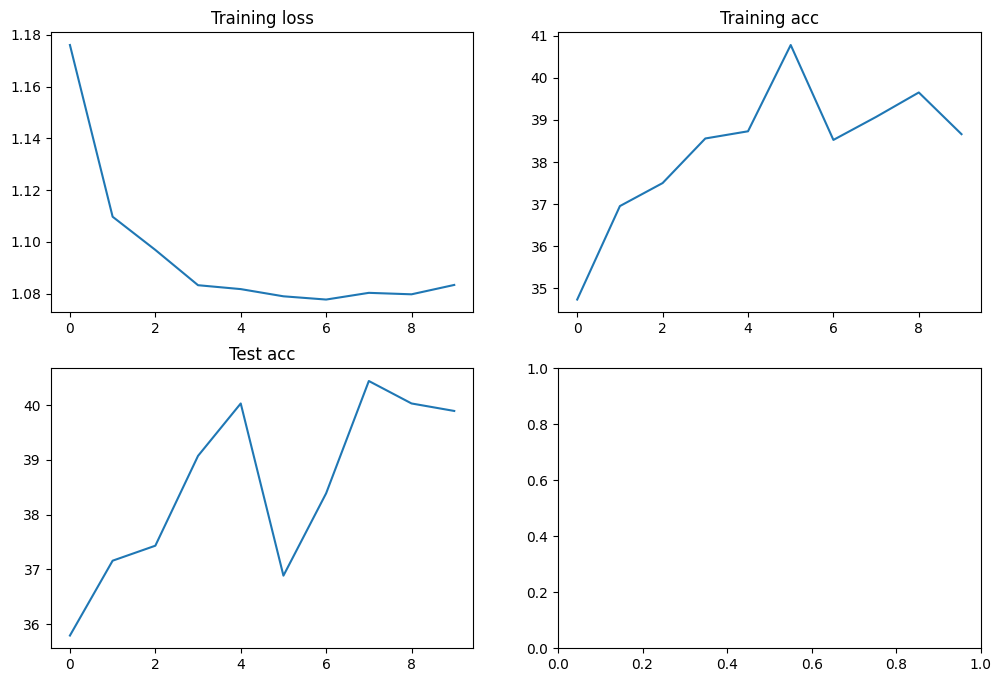

In [314]:
# plot the stats
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

In [66]:
# X_train.head()

## Part 5: Neural Network Model Training with Embeddings Extracted from Clip

### 5.1 Extract pictures' embeddings via vision transformers 

In [67]:
# model, preprocess = clip.load("ViT-B/32", device=device)

In [68]:
# image_features_train = []
# for image_path in tqdm(X_train['image_path']):
#     image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model.encode_image(image)
#     image_features_train.append(image_features.cpu().numpy())

In [69]:
# image_features_test = []
# for image_path in tqdm(X_test['image_path']):
#     image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model.encode_image(image)
#     image_features_test.append(image_features.cpu().numpy())

In [70]:
# features_train = np.concatenate((X_train_scaled, np.vstack(image_features_train)), axis=1)
# features_test = np.concatenate((X_test_scaled, np.vstack(image_features_test)), axis=1)

In [71]:
# np.save('features_train.npy', features_train)
# np.save('features_test.npy', features_test)

In [394]:
features_train = np.load('features_train.npy')
features_test = np.load('features_test.npy')

### 5.2 Model building

#### 5.2.1 Data ETL Pipeline building

In [132]:
class AllDataset(Dataset):

    def __init__(self, data, labels):

        self.X = torch.tensor(data.astype(np.float32))
        self.Y =  torch.tensor(labels)

    def __getitem__(self, idx):

        x = self.X[idx]
        y  = self.Y[idx]

        return x, y

    def __len__(self):
        return len(self.Y)

In [133]:
train_dataset = AllDataset(features_train,encoded_labels_train)
test_dataset = AllDataset(features_test, encoded_labels_test)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

#### 5.2.2 Model training

In [160]:
class NN(nn.Module):
    
    def __init__(self, hidden_units, dropout_rate=0., use_bn = False):

        super(NN, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout_rate)
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])
    
    def forward(self, x):
        
        for i, linear in enumerate(self.dnn_network):
            x = linear(x)
            if self.use_bn:
                x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        return x

In [167]:
hidden_units = [520, 256, 128, 3]
dnn_dropout = 0.6
model_3 = NN(hidden_units, dnn_dropout, use_bn=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-3)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
# model_3.to(device)

In [168]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=10):

    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader) #(100 * correct) / (32 * len(trainloader))
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [169]:
# This function is called out after each epoch of training on the training data to measure the accuracy of the model
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

In [170]:
model_3, training_losses, training_accs, test_accs = train_model(model_3, criterion, optimizer, lrscheduler, n_epochs=20)

  5%|▌         | 1/20 [00:00<00:06,  2.96it/s]

Epoch 1, duration: 0 s, loss: 1.3214, acc: 34.7147
Accuracy of the network on the test images: 47 %


 10%|█         | 2/20 [00:00<00:05,  3.03it/s]

Epoch 2, duration: 0 s, loss: 1.1690, acc: 36.9905
Accuracy of the network on the test images: 49 %


 15%|█▌        | 3/20 [00:00<00:05,  3.07it/s]

Epoch 3, duration: 0 s, loss: 1.1298, acc: 37.7038
Accuracy of the network on the test images: 49 %


 20%|██        | 4/20 [00:01<00:05,  3.02it/s]

Epoch 4, duration: 0 s, loss: 1.0726, acc: 39.3682
Accuracy of the network on the test images: 50 %


 25%|██▌       | 5/20 [00:01<00:04,  3.05it/s]

Epoch 5, duration: 0 s, loss: 1.0732, acc: 38.9606
Accuracy of the network on the test images: 50 %


 30%|███       | 6/20 [00:01<00:04,  3.07it/s]

Epoch 6, duration: 0 s, loss: 1.0421, acc: 40.9647
Accuracy of the network on the test images: 51 %


 35%|███▌      | 7/20 [00:02<00:04,  3.14it/s]

Epoch 7, duration: 0 s, loss: 1.0481, acc: 39.8777
Accuracy of the network on the test images: 51 %


 40%|████      | 8/20 [00:02<00:03,  3.20it/s]

Epoch 8, duration: 0 s, loss: 1.0454, acc: 40.9986
Accuracy of the network on the test images: 52 %


 45%|████▌     | 9/20 [00:02<00:03,  3.23it/s]

Epoch 9, duration: 0 s, loss: 1.0450, acc: 40.0136
Accuracy of the network on the test images: 52 %


 50%|█████     | 10/20 [00:03<00:03,  3.25it/s]

Epoch 10, duration: 0 s, loss: 1.0336, acc: 40.2174
Accuracy of the network on the test images: 51 %


 55%|█████▌    | 11/20 [00:03<00:02,  3.27it/s]

Epoch 11, duration: 0 s, loss: 1.0471, acc: 40.2853
Accuracy of the network on the test images: 52 %


 60%|██████    | 12/20 [00:03<00:02,  3.28it/s]

Epoch 12, duration: 0 s, loss: 1.0422, acc: 39.9117
Accuracy of the network on the test images: 52 %


 65%|██████▌   | 13/20 [00:04<00:02,  3.21it/s]

Epoch 13, duration: 0 s, loss: 1.0375, acc: 39.6399
Accuracy of the network on the test images: 51 %


 70%|███████   | 14/20 [00:04<00:01,  3.23it/s]

Epoch 14, duration: 0 s, loss: 1.0355, acc: 41.3383
Accuracy of the network on the test images: 52 %


 75%|███████▌  | 15/20 [00:04<00:01,  3.29it/s]

Epoch 15, duration: 0 s, loss: 1.0300, acc: 40.9986
Accuracy of the network on the test images: 51 %


 80%|████████  | 16/20 [00:05<00:01,  3.31it/s]

Epoch 16, duration: 0 s, loss: 1.0364, acc: 40.4891
Accuracy of the network on the test images: 52 %


 85%|████████▌ | 17/20 [00:05<00:00,  3.30it/s]

Epoch 17, duration: 0 s, loss: 1.0408, acc: 39.5041
Accuracy of the network on the test images: 52 %


 90%|█████████ | 18/20 [00:05<00:00,  3.29it/s]

Epoch 18, duration: 0 s, loss: 1.0473, acc: 39.1304
Accuracy of the network on the test images: 52 %


 95%|█████████▌| 19/20 [00:05<00:00,  3.29it/s]

Epoch 19, duration: 0 s, loss: 1.0443, acc: 40.7609
Accuracy of the network on the test images: 52 %


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]

Epoch 20, duration: 0 s, loss: 1.0575, acc: 38.9606
Accuracy of the network on the test images: 52 %
Finished Training


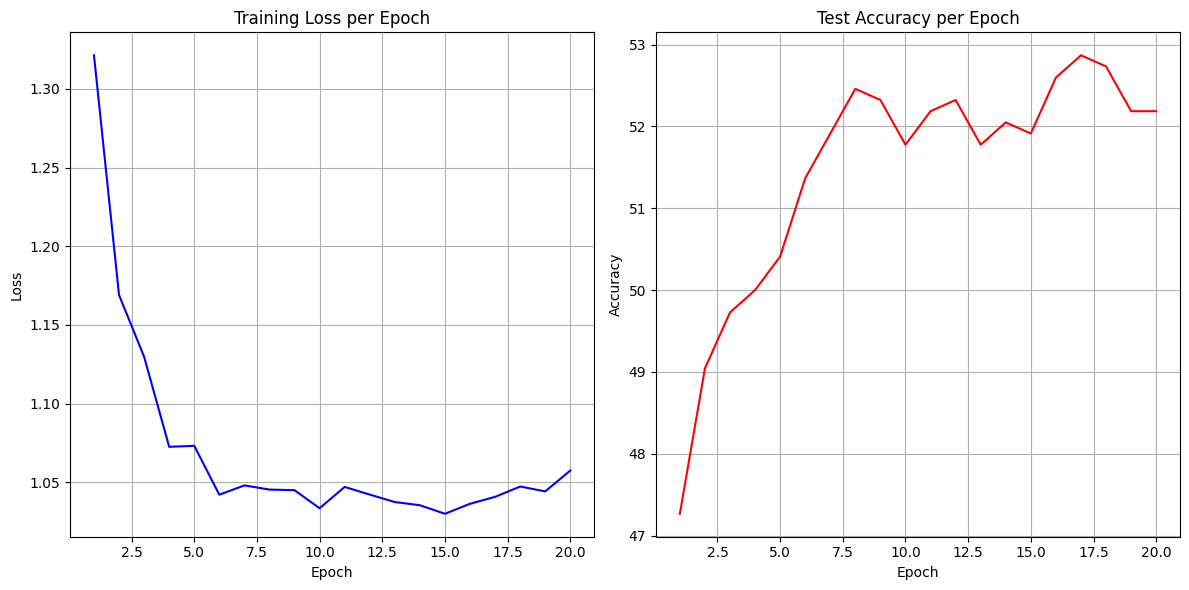

In [172]:
epochs = list(range(1, 21))
plt.figure(figsize=(12, 6))

# Plot for Training Loss
plt.subplot(1, 2, 1)  
plt.plot(epochs, training_losses, label='Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot for Test Accuracy
plt.subplot(1, 2, 2)  
plt.plot(epochs, test_accs, label='Test Accuracy', color='red')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 6: Train Traditional Models with Both Images Features and Metadata

In [396]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, y_train)
y_pred_knn = knn.predict(features_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy for knn: {accuracy_knn}")

Accuracy for knn: 0.5450819672131147


In [399]:
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
Grid_RF.fit(features_train, y_train)
print_grid_search_metrics(Grid_RF)

Best score: 0.7144292237442922
Best parameters set:
max_depth:10
n_estimators:100


In [400]:
rf = Grid_RF.best_estimator_
rf.fit(features_train, y_train)
y_pred_rf = rf.predict(features_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy for random forest: {accuracy_rf}")

Accuracy for random forest: 0.7090163934426229


Models with both images and metadata does not outperform models using just nemerical metadata.